# Test sample and feature weight

This notebook explores whether weighting each sample with the number of events improve the accuracy of the prediction? 
  * What is an appropiate weight for devices without events?
  * Should the weight be capped? 
  * How should it increase with number of events?
  
Unfortunately, various possible weighting scheme (normalized, linear, exponential) all decreased the score. I do not understand this, requires further work and better understanding the the lbfgs solver.

In [149]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import time

#import sys
#import pymongo
#import bson.objectid
#pymongo.objectid = bson.objectid
#sys.modules["pymongo.objectid"] = bson.objectid

#os.environ['KERAS_BACKEND']='tensorflow'
os.environ['THEANO_FLAGS'] = 'device=cpu'
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import Callback
import keras

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import log_loss
import pickle

In [150]:
dir_in = 'data_ori'
dir_feat = 'data'
rs = 123
fixed_seed_num = 1234
np.random.seed(fixed_seed_num)
random.seed(fixed_seed_num) # not sure if needed or not

feature_files_old = ['features_bag_brand',
                 'features_bag_model',
                'features_bag_label_installed',
                'features_bag_app_installed']
feature_files = ['features_brand_bag',
                 'features_brand_model_bag',
                'features_label_app_installed',
                'features_appid_installed']
feature_files=feature_files[0:2]
# Function to read feature file
def open_feature_file(fname, samples='train'):
    with open(os.path.join(dir_feat, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
        return pickle.load(f)

In [151]:
# Calculate CV score on Xtrain, y
def score(X, clf = None, random_state = 123, w = None):
    if not clf: clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs', n_jobs=2)
        
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = X[itrain, :], X[itest, :]
        ytr, yte = y[itrain], y[itest]
        if np.any(w):
            ws = w[itrain]
        else:
            ws = None
            
        clf.fit(Xtr, ytr, sample_weight = ws)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    #print('')
    return log_loss(y, pred)

## Get basescore on installed bag of apps

In [152]:
gatrain = pd.read_csv(os.path.join(dir_in,'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(dir_in,'gender_age_test.csv'))
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [117]:
fw = [1, 1, 1, 1]
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
# Weird linear scaling of features decreases performance.
# *1.0: Basescore: 2.27402
# *1.1: Basescore: 2.27443
# *1.2: Basescore: 2.27534
# *0.5: Basescore: 2.28733
Xtest = hstack([open_feature_file(f,'test') for f in feature_files],format='csr')

In [118]:
print('Training on {} features'.format(Xtrain.shape[1]))
basescore = score(Xtrain, random_state=rs)
print('Basescore: {:.5f}'.format(basescore))

Training on 1798 features
Basescore: 2.39530


## Test Keras model

In [119]:
dummy_y = np_utils.to_categorical(y)

In [143]:
def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator (https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch, np.ones(X_batch.shape[0])
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch#, np.ones(X_batch.shape[0])
        if (counter == number_of_batches):
            counter = 0

# define baseline model
params = {'optimizer': 'adamax',
          'batch_size': 400,
          'n_epoch': 3,
         'layer_1': {'on': True,
                     'units': 100,
                     'activation': 'relu',
                     'dropout': 0.2},
         'layer_2': {'on': True,
                    'units': 150,
                    'activation': 'tanh',
                    'dropout': 0.2},
          'layer_3': {'on': False,
                     'units': 12,
                     'activation': 'sigmoid',
                     'dropout': 0.2}
          }


def baseline_model(params):
    # create model
    model = Sequential()
    model.add(Dense(params['layer_1']['units'], 
                    input_dim=Xtrain.shape[1], 
                    init='normal', 
                    activation=params['layer_1']['activation']))
    
    model.add(Dropout(params['layer_1']['dropout']))
    
    if params['layer_2']['on']:
        model.add(Dense(params['layer_2']['units'], 
                        input_dim=Xtrain.shape[1], 
                        init='normal', 
                        activation=params['layer_2']['activation']))
        #https://www.kaggle.com/poiss0nriot/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/run/328610
        #model.add(PReLU())
        model.add(Dropout(params['layer_2']['dropout']))
    
    if params['layer_3']['on']:
        model.add(Dense(params['layer_3']['units'], 
                        init='normal', 
                        activation=params['layer_3']['activation']))
        
        model.add(Dropout(params['layer_3']['dropout']))
    
    model.add(Dense(12, init='normal', activation='softmax'))    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])  #logloss
    return model

def plot_loss_progress(pred_hist_obj, ax1=None, ax2=None, c='g'):
    
    df = pred_hist_obj.predhist
    
    if not ax1:
        fig, (ax1, ax2) = plt.subplot(1, 2, figsize=(16,4))
        
    df.plot(y='acc', ax=ax1, label=pred_hist_obj.tag, color=c)
    df.plot(y='val_acc', ax=ax1, label=pred_hist_obj.tag, linestyle='--', color=c)
    ax1.set_title('Accuracy score')
    ax1.set_xlabel('Epoch #')
    ax1.set_ylabel('Accuracy')
    
    df.plot(y='logloss', ax=ax2, label=pred_hist_obj.tag, color=c)
    df.plot(y='val_logloss', ax=ax2, label=pred_hist_obj.tag, linestyle='--', color=c)
    ax2.set_title('Logloss score')
    ax2.set_xlabel('Epoch #')
    ax2.set_ylabel('Logloss')

class prediction_hist(Callback):
    def __init__(self, tag=''):
        self.predhist = pd.DataFrame(columns=['acc','logloss','val_acc','val_logloss'])
        self.tag = str(tag)
        
    def on_epoch_end(self, epoch, logs={}):
        print logs.values()
        self.predhist.loc[epoch] = logs.values()
        

Train on 67180 samples, validate on 7465 samples
Epoch 1/7
[0.14234891336796077, 2.4066272961167079, 0.14762223710749506, 2.4019252323896709]
9s - loss: 2.4066 - acc: 0.1423 - val_loss: 2.4019 - val_acc: 0.1476
Epoch 2/7
[0.15208395355760643, 2.3925148615988991, 0.14521098459677176, 2.3994269013325003]
13s - loss: 2.3925 - acc: 0.1521 - val_loss: 2.3994 - val_acc: 0.1452
Epoch 3/7
[0.15705567133119683, 2.3856552006908029, 0.1482920294718621, 2.3966550705341869]
14s - loss: 2.3857 - acc: 0.1571 - val_loss: 2.3967 - val_acc: 0.1483
Epoch 4/7


KeyboardInterrupt: 

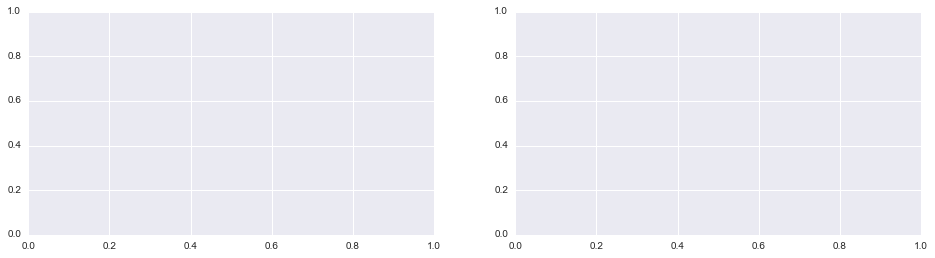

In [144]:


X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, 
                                                  test_size=0.1, random_state=42)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
drs = [0.1, 0.2, 0.3, 0.4, 0.5]
optim = ['adamax', 'adam', 'nadam', 'adadelta']
cs = 'grbycm'
for i,dr in enumerate(optim):
    hist_all = prediction_hist(tag=optim)
    
    model=baseline_model(params)
    
    fit=model.fit(X_train.todense(), y_train, nb_epoch = 7, batch_size=32,
                             validation_data=(X_val.todense(), y_val), verbose=2,
                 callbacks=[hist_all]) 
    
    plot_loss_progress(hist_all, ax1=ax1, ax2=ax2, c=cs[i])

In [139]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_154 (Dense)                (None, 100)           179900      dense_input_52[0][0]             
____________________________________________________________________________________________________
dropout_52 (Dropout)             (None, 100)           0           dense_154[0][0]                  
____________________________________________________________________________________________________
dense_155 (Dense)                (None, 150)           15150       dropout_52[0][0]                 
____________________________________________________________________________________________________
dropout_53 (Dropout)             (None, 150)           0           dense_155[0][0]                  
___________________________________________________________________________________________

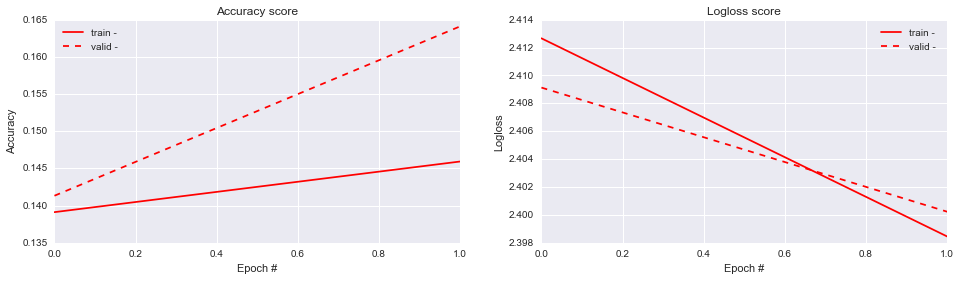

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

cs = 'grbycm'
plot_loss_progress(hist_all, ax1=ax1, ax2=ax2, c=cs[i])

        acc   logloss   val_acc  val_logloss
0  0.139632  2.414896  0.146015     2.407184
1  0.147048  2.399283  0.152043     2.402222
2  0.149834  2.395062  0.160750     2.398118
3  0.152792  2.391880  0.156731     2.396691
4  0.153764  2.388416  0.158741     2.395327


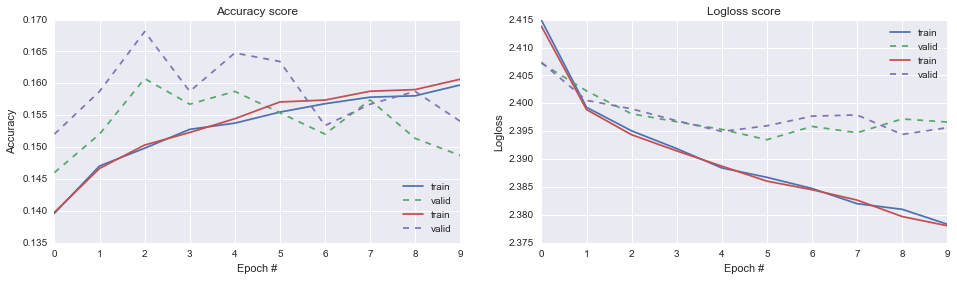

In [98]:
print hist_generator.predhist.head()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
plot_loss_progress(hist_all, ax1=ax1, ax2=ax2)

In [14]:
# evaluate the model
scores_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])

print('logloss val {}'.format(log_loss(y_val, scores_val)))

logloss val 2.28769795387


In [11]:
basescore = 2.27506319419 (2.2751433925) with weight in batch_generator: 2.2751433925, 2.2751433925

SyntaxError: invalid syntax (<ipython-input-11-d5322ce035bd>, line 1)

In [ ]:
pred = pd.DataFrame(scores, index = gatest['device_id'], columns=targetencoder.classes_)
pred.to_csv('A_keras_model_on_apps_and_labels.csv',index=True)

## Fit on complete model

In [36]:
model=baseline_model()
fit=model.fit(X_train.todense(), y_train, nb_epoch = 20, batch_size=32,
                         validation_data=(X_val.todense(), y_val), verbose=2)

Train on 73152 samples, validate on 1493 samples
Epoch 1/20
77s - loss: 2.3393 - acc: 0.1693 - val_loss: 2.3045 - val_acc: 0.1775
Epoch 2/20
117s - loss: 2.2752 - acc: 0.1924 - val_loss: 2.2946 - val_acc: 0.1949
Epoch 3/20
133s - loss: 2.2494 - acc: 0.2045 - val_loss: 2.2790 - val_acc: 0.1962
Epoch 4/20
141s - loss: 2.2294 - acc: 0.2127 - val_loss: 2.2695 - val_acc: 0.2029
Epoch 5/20
145s - loss: 2.2108 - acc: 0.2206 - val_loss: 2.2705 - val_acc: 0.2043
Epoch 6/20
149s - loss: 2.1939 - acc: 0.2275 - val_loss: 2.2757 - val_acc: 0.2076
Epoch 7/20
152s - loss: 2.1764 - acc: 0.2362 - val_loss: 2.2819 - val_acc: 0.1969
Epoch 8/20
153s - loss: 2.1600 - acc: 0.2423 - val_loss: 2.2757 - val_acc: 0.2016
Epoch 9/20
156s - loss: 2.1437 - acc: 0.2477 - val_loss: 2.2978 - val_acc: 0.2016
Epoch 10/20
157s - loss: 2.1275 - acc: 0.2544 - val_loss: 2.3055 - val_acc: 0.2016
Epoch 11/20
159s - loss: 2.1105 - acc: 0.2613 - val_loss: 2.3123 - val_acc: 0.2050
Epoch 12/20
160s - loss: 2.0947 - acc: 0.2678 - 

In [32]:
# evaluate the model
scores_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])
print('logloss val {}'.format(log_loss(y_val, scores_val)))

logloss val 2.27838215347


In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_31 (Dense)                 (None, 10)            215280      dense_input_11[0][0]             
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 10)            0           dense_31[0][0]                   
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 50)            550         dropout_11[0][0]                 
____________________________________________________________________________________________________
dense_33 (Dense)                 (None, 12)            612         dense_32[0][0]                   
Total params: 216442
______________________________________________________________________